In [1]:
import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.spatial import Delaunay

In [7]:
# Read graph data into dataframe, remove unnecessary columns, only keep december months
graph_data = pd.read_csv('san_francisco-censustracts-2017-4-All-MonthlyAggregate.csv')
graph_data = graph_data.drop(['standard_deviation_travel_time', 'geometric_mean_travel_time', 'geometric_standard_deviation_travel_time'], axis=1)
graph_data = graph_data.drop(graph_data[graph_data.month != 12].index)
dec_data = graph_data.drop(['month'], axis=1)

In [10]:
# Remove duplicates and keep the mean of duplicate travel times
dec_array = np.asarray(dec_data) # idk numpy seems easier to work with
existing_paths = {}
for row in dec_array:
    locations = tuple(np.sort(row[0:2]))
    if locations in existing_paths:
        existing_paths[locations].append(row[2])
    else:
        existing_paths[locations] = [row[2]]
#dec_data.to_csv('december_data.csv',header=False,index=False)

In [11]:
# Write out a csv file with december data, where duplicates are averaged
# This will be used in R's igraph library to do graph analysis
with open('december_data.csv','w') as f:
    for locations in existing_paths:
        string = '{} {} {:.2f}\n'.format(int(locations[0]),int(locations[1]),np.mean(existing_paths[locations]))
        f.write(string)

In [12]:
# Load in the location data
with open('san_francisco_censustracts.json') as json_data:
    geo_data = json.load(json_data)
geo_data = geo_data['features']

In [13]:
# Process the raw data into a dictionary where key is location ID, value is display name and coordinate list
location_dictionary = {}

for entry in geo_data:
    data = {}
    # Retrieve coordinate list and compute mean coordinates
    coord_list = entry['geometry']['coordinates'][0][0]
    mean_coord = np.mean(np.asarray(coord_list),axis=0)
    movement_id = entry['properties']['MOVEMENT_ID']

    data['coord_list'] = coord_list
    data['mean_coord'] = mean_coord
    data['display_name'] = entry['properties']['DISPLAY_NAME']
    location_dictionary[movement_id] = data

In [14]:
mean_coords = np.zeros((len(geo_data),2))
for n,location_key in enumerate(location_dictionary):
    mean_coords[n,:] = location_dictionary[location_key]['mean_coord']

In [15]:
c = geo_data[0]['geometry']['coordinates'][0][0]
np.mean(np.asarray(c),axis=0)

array([-120.78868462,   36.07162944])

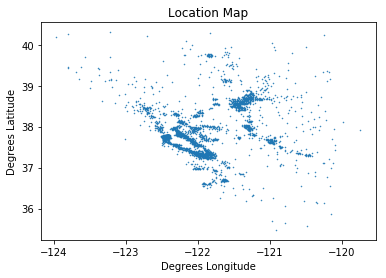

In [20]:
plt.scatter(mean_coords[:,0],mean_coords[:,1],s=1,marker='.')
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Location Map')
plt.show()

In [21]:
tri = Delaunay(mean_coords)

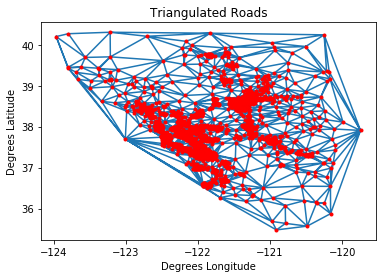

In [22]:
plt.triplot(mean_coords[:,0], mean_coords[:,1], tri.simplices.copy())
plt.plot(mean_coords[:,0], mean_coords[:,1],'r.')
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Triangulated Roads')
plt.show()